In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline


import os

data_path = '/home/fterroso/data/'

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d') #datetime.datetime.now()
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def generate_n_trips_series_fn(source_type):
    ntrips = []
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join('data', 'OD', 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ntrips.append((date, od_date.loc['total', 'total']))
    n_trips_df = pd.DataFrame.from_records(ntrips, columns='date num_trips_{}'.format(source_type).split())
    n_trips_df= n_trips_df.set_index('date')
    return n_trips_df

### Read TWT trips

In [4]:
n_twt_trips_df = generate_n_trips_series_fn('TWT')

In [5]:
n_twt_trips_df.iloc[7]

num_trips_TWT    0
Name: 2020-04-08 00:00:00, dtype: int64

In [6]:
n_twt_trips_df.iloc[7]['num_trips_TWT']=n_twt_trips_df.iloc[6]['num_trips_TWT']/2
n_twt_trips_df.iloc[6]['num_trips_TWT']=n_twt_trips_df.iloc[6]['num_trips_TWT']/2

In [7]:
n_twt_trips_df.head(3)

,num_trips_TWT
date,
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503


In [8]:
n_twt_trips_df.tail(3)

,num_trips_TWT
date,
2020-06-18,4375
2020-06-19,4738
2020-06-20,2006


In [9]:
n_twt_trips_df[n_twt_trips_df['num_trips_TWT']==n_twt_trips_df['num_trips_TWT'].max()]

,num_trips_TWT
date,
2020-06-19,4738


In [10]:
n_twt_trips_df[n_twt_trips_df['num_trips_TWT']==n_twt_trips_df['num_trips_TWT'].min()]

,num_trips_TWT
date,
2020-04-04,554


### Read INE trips

In [11]:
n_ine_trips_df = generate_n_trips_series_fn('INE')

In [12]:
n_ine_trips_df.head(3)

,num_trips_INE
date,
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095


In [13]:
n_ine_trips_df.tail(3)

,num_trips_INE
date,
2020-06-18,5439425
2020-06-19,5519725
2020-06-20,4626546


## Plot number of trips evolution

In [14]:
#n_twt_trips_df['num_trips_INE'] = n_ine_trips_df['num_trips_INE']

In [15]:
n_twt_trips_df.head()

,num_trips_TWT
date,
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


In [16]:
covid_cases_df = pd.read_csv(os.path.join(data_path,'Spain-INE-covid-mob-study-mar-jun-20','COVID datos_provincias.csv'), sep=';')
target_covid_cases_df = covid_cases_df[covid_cases_df['mes'].isin([4, 5, 6])]
target_covid_cases_df.head()

,Provincia_cod,dia,mes,num_casos
61,1,1,4,52
62,1,2,4,46
63,1,3,4,70
64,1,4,4,25
65,1,5,4,33


In [30]:
def generate_covid_time_series_fn():
    num_cases_trips = []
    for date_ in target_days:
        month = date_.month
        day = date_.day
        n_covid_cases = covid_cases_df[(covid_cases_df['dia']==day) & (covid_cases_df['mes']==month)]['num_casos'].sum()
        num_cases_trips.append((date_, n_covid_cases))
    
    df=  pd.DataFrame.from_records(num_cases_trips,columns='date COVID_cases'.split())
    return df.set_index('date')

In [31]:
covid_cases_df = generate_covid_time_series_fn()

### INE vs COVID

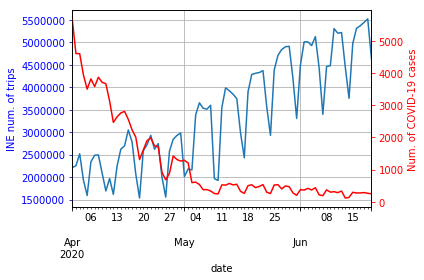

In [38]:
ax= n_ine_trips_df['num_trips_INE'].plot(grid=True);
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
covid_cases_df['COVID_cases'].plot(ax=ax2, color='red');

ax.set_ylabel('INE num. of trips')
ax2.set_ylabel('Num. of COVID-19 cases')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_n_trips_vs_covid_ma.png'))

In [40]:
import scipy.stats as stats

In [42]:
r, p = stats.pearsonr(n_ine_trips_df['num_trips_INE'], 
                      covid_cases_df['COVID_cases'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.6264849293851205 and p-value: 3.957715676021759e-10


### TWT vs COVID

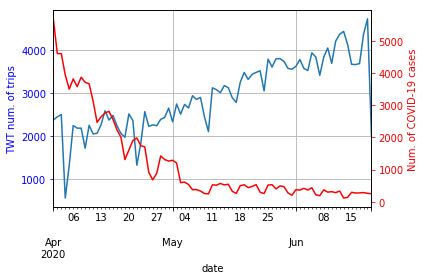

In [39]:
ax= n_twt_trips_df['num_trips_TWT'].plot(grid=True);
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
covid_cases_df['COVID_cases'].plot(ax=ax2, color='red');

ax.set_ylabel('TWT num. of trips')
ax2.set_ylabel('Num. of COVID-19 cases')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_n_trips_vs_covid_ma.png'))

In [43]:
r, p = stats.pearsonr(n_twt_trips_df['num_trips_TWT'], 
                      covid_cases_df['COVID_cases'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.6584276776290034 and p-value: 2.382718059416771e-11


### TWT vs INE

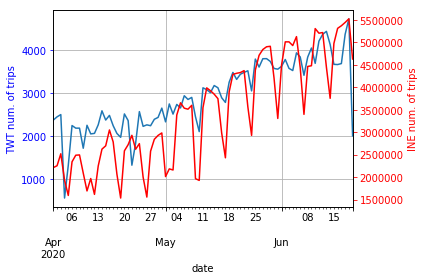

In [18]:
ax= n_twt_trips_df['num_trips_TWT'].plot(grid=True);
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))

n_ine_trips_df['num_trips_INE'].plot(ax=ax2, color='red');

ax.set_ylabel('TWT num. of trips')
ax2.set_ylabel('INE num. of trips')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'num_trips_twt_vs_ine.png'))

## Split into time series

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

/home/fterroso/python/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


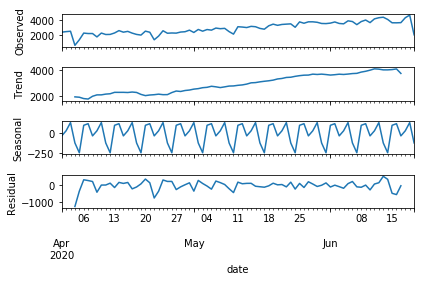

In [20]:
result = seasonal_decompose(n_twt_trips_df, model='additive', freq=7);
result.plot();
plt.tight_layout()
plt.savefig(os.path.join('figs', 'num_trips_decomposition_twt.png'))

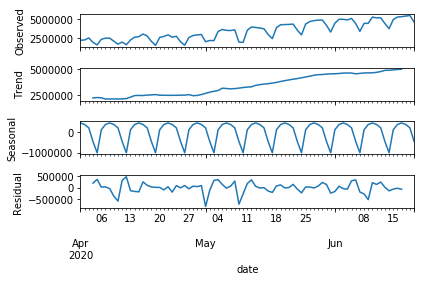

In [21]:
result = seasonal_decompose(n_ine_trips_df, model='additive', freq=7);
result.plot();
plt.tight_layout()
plt.savefig(os.path.join('figs', 'num_trips_decomposition_ine.png'))

In [22]:
from dtw import dtw,accelerated_dtw

In [23]:
n_twt_trips_df['num_trips_INE'] = n_ine_trips_df['num_trips_INE']

In [24]:
n_twt_trips_df.head()

,num_trips_TWT,num_trips_INE
date,,
2020-04-01,2375,2213123
2020-04-02,2450,2254121
2020-04-03,2503,2520095
2020-04-04,554,1934554
2020-04-05,1319,1593385


In [25]:
import scipy.stats as stats

## Pearson correlation

In [26]:
r, p = stats.pearsonr(n_twt_trips_df.dropna()['num_trips_TWT'], n_twt_trips_df.dropna()['num_trips_INE'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.8543051890619978 and p-value: 3.6929656687881084e-24


## Time Lagged Cross Correlation

In [27]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

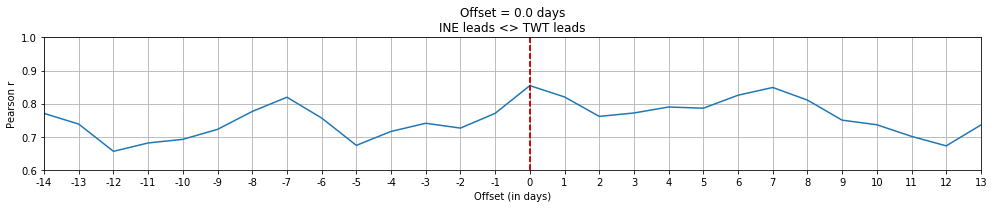

In [28]:
d1 = n_twt_trips_df['num_trips_INE']
d2 = n_twt_trips_df['num_trips_TWT']
rs = [crosscorr(d1,d2, lag) for lag in range(-14,14)]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} days\nINE leads <> TWT leads',ylim=[0.6,1],xlim=[0,24], xlabel='Offset (in days)',ylabel='Pearson r')
ax.set_xticks(np.arange(0,28))
ax.set_xticklabels(np.arange(-14,14));
ax.grid(True)
#ax.set_grid(True)
#plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('figs', 'time_lagged_correlation.png'))